In [2]:
from generate_data import Data
from evaluate import *
from models import *

from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [5]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2], permutation_intervals=2)

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 1.81 s
Wall time: 1.87 s


In [6]:
%%time
train, val, test = data.get_splits(['1st_interval', 'omit_distances'], [[1]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 1801 train | 406 val | 1624 test
CPU times: total: 27.1 s
Wall time: 27.1 s


#### Peek at unshuffled train data

In [7]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', 'V'],
 [',___._.,_.,,..,_', 'w_.,.,._,_._..,,', ',cr,__,,._._.,,_', 'V'],
 [',_..,__......___', 'w__.____,_,..___', '.,cr_.__._.,..._', 'V'],
 ['_.,,.,....,__._,', 'w,.,.,.___,_,_,_', '.._cr_.___.,,,.,', 'V'],
 [',.._.._,_...,.,_', 'w.__,,_,,_,__..,', '..,_cr_.,.,_.___', 'V'],
 [',,.._.....,,,,,_', 'w_,.._.,...,_.,_', '...__cr..,__,_..', 'V'],
 ['__....,,,._..,,.', 'w.._.,.,__.,.__.', '._..,_cr.,_,__.,', 'V'],
 [',,,__..__.____,.', '_w__,_._,,.__,,.', 'cr...__,..,,__,.', 'V'],
 ['..,._,.__.,__,,_', ',w,_,..__,_,_,..', '_cr,._,__.._,___', 'V'],
 [',.,.,,__,,._.,__', ',w,,_,.__..__,,,', '_,cr_,.,._____.,', 'V'],
 [',__._,_.___._.,_', '.w..._,__.__.___', ',,,cr,,__..._,,.', 'V'],
 ['__,,._,..,,,._,_', '_w.___,.,,,.,,._', '__..cr__.,.,,._.', 'V'],
 ['_,,,,,._.,..,___', '.w,_.,_,__,.,__,', '.,..,cr.__...,..', 'V'],
 [',,_._,._,.,....,', '.w.,,,_____.,.._', '.,_,_,cr_._,,,..', 'V'],
 ['.,....__,___,,_,', '_.w.,,,_._..,_._', 'cr_,_

In [8]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 85 | F2-uw 85 | F2-w 98 | F2-noop 98 | 
F3 cr:    F2-wu 85 | F2-uw 85 | F2-w 98 | F2-noop 98 | 
F3 r:    F2-wu 98 | F2-uw 98 | F2-w 162 | F2-noop 169 | 
F3 noop:    F2-wu 98 | F2-uw 98 | F2-w 169 | F2-noop 177 | 

Positive samples count: 808
Total samples count: 1801
Positive class ratio: 0.4486396446418656


#### Peek at test data

In [9]:
test_original[:15]

[['_,..,_.,,_..,.,.', '.._,.,..,_,_,__.', '_,____,__,_._,_.', 'V'],
 ['._,_._.._,_,.._.', '._._,,_,.,w.,,,.', '__,,..___.,d_r._', 'D'],
 ['._.,,__,___,,,..', '__.,,._,w.u..._,', ',,.__..,,,c_r.,,', 'V'],
 ['..__._...,._,,_.', ',______.,,.,,.__', '..__,.c,r__.,__,', 'V'],
 ['__,.._.,.,,,,._,', ',.._,_.,_.,._u.w', '_.__..,c_r,_._._', 'V'],
 ['._.,____,,..__._', '.._._.,___,.,,,,', '__..___..._,,_..', 'V'],
 ['.,,_,,,..___.,_.', ',u,w_..__.,_,._.', ',_d_r.,_,.,,.._.', 'A'],
 ['.,,._.,__._.___,', '.,,,..u,w.._._,.', '.__._._,,.__,,,.', 'V'],
 ['._,..,,_,._..___', '.,,__,,w_,.__,_,', ',____.,..__..__.', 'V'],
 ['_,.._.,.__,,_,,.', ',,,..,,_,__,.___', '.,__,__,_,...,__', 'V'],
 ['._,___,,._,.,,..', ',,_.,__,,.._.___', ',c.r.._,_.,,.__,', 'V'],
 ['_.__,.,__..,,,_.', ',.._,___._,__.,_', '_.____.._.,.c.r,', 'V'],
 ['_._,___.._..,._,', ',,..,,___w_u,,._', ',,_,,.,.,.r,.,_.', 'R'],
 ['.,_.,_.,,.,._,.,', '_,._.,,,,..,w,_,', ',.___..,_d,r._,.', 'D'],
 ['__,__._,,.__.,_,', '_..,,,_.,.u,w_._', '___,_

In [10]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 84 | F2-uw 69 | F2-w 86 | F2-noop 87 | 
F3 cr:    F2-wu 77 | F2-uw 77 | F2-w 83 | F2-noop 90 | 
F3 r:    F2-wu 79 | F2-uw 91 | F2-w 140 | F2-noop 157 | 
F3 noop:    F2-wu 88 | F2-uw 88 | F2-w 158 | F2-noop 170 | 

Positive samples count: 709
Total samples count: 1624
Positive class ratio: 0.43657635467980294


#### Peek at val data

In [11]:
val_original[:15]

[['.,,._,__..,.,.,_', ',,_..,w,u_.__._,', ',.,,_...,..__,_,', 'V'],
 ['_,..,.._,.,,,_.,', ',__,_,_..,.._,,.', '.,.,,,.,_,_,,.._', 'V'],
 ['_,._,_.,..,_.___', '...,,,,__..u,w..', ',_,._,_..,,_,.,_', 'V'],
 ['..__,,...._.__,.', '__,.._,_,u.w,_..', '.,____._,.._d.r.', 'A'],
 [',_.__.__,._,,_..', ',w_u,,.,.,,,,_.,', '_,_.,_,,,_,_,_..', 'V'],
 ['.,,,____,,,..__.', '_,._._w..._...._', ',,..d,r,_..,_,_.', 'D'],
 ['_._,.._....,.,__', '.._.,,,.,,._w._,', '_,__,.,r__,..,..', 'R'],
 ['_..._.__..___,._', ',_,.,...,,.w,u_.', ',.._,_,_,.__r,_,', 'R'],
 ['..,_,,,,,,.,_._.', '_....,,,.,.__w,_', ',,_,.,,____.r_,_', 'R'],
 [',__,._.,._,,_.__', '____,._,.._.,,w_', '.._..,_,__r,,.__', 'R'],
 [',_,.,.,_..,..,,,', ',,,,.._.,,..,_,_', ',.__.,_._,.,_,.,', 'V'],
 [',_,.,_,,_.__....', ',,.,,,.,,,_,,_.,', ',__.,.,,_.,_._._', 'V'],
 ['.,,.....,,_,_._,', '___w_,,,..__,_.,', 'c_r.._____,.,..,', 'V'],
 ['.,..,.,_,,,__,.,', ',_,.__.,_.,,,,__', ',.,,..___.r.___,', 'R'],
 [',,,_.__._,_,_.,,', '.u,w_,.,,...,,_,', ',,_,_

In [12]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 14 | F2-uw 29 | F2-w 19 | F2-noop 25 | 
F3 cr:    F2-wu 21 | F2-uw 21 | F2-w 22 | F2-noop 22 | 
F3 r:    F2-wu 26 | F2-uw 14 | F2-w 37 | F2-noop 35 | 
F3 noop:    F2-wu 24 | F2-uw 24 | F2-w 34 | F2-noop 39 | 

Positive samples count: 185
Total samples count: 406
Positive class ratio: 0.45566502463054187


#### Send label arrays to device

In [13]:
#y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
#y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
#y_test = torch.from_numpy(y_test.astype(float)).float().to(device)
#---------------------------------------------------------------------------------------CAMBIO
# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

#### Get data in normal format (same as CNN format)

In [14]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [15]:
x_train_normal[0].shape

torch.Size([1801, 128])

#### Get data in convolutional format, send to device

In [16]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [17]:
x_train_cnn[0].shape

torch.Size([1801, 160])

#### Get data in LSTM format, send to device

In [18]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [19]:
x_train_lstm[0].shape

torch.Size([1801, 18, 8])

### Define training parameters

In [20]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "f2_f4_easy_redo"

### Define training procedure for each model

In [21]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | METRICS:")
        print("Accuracy ", accuracies[-1]['Overall'])
        print("Precision ", precisions[-1]['Overall'])
        print("Recalls ", recalls[-1]['Overall'])
        print("F1_scores ", f1_scores[-1]['Overall'])
        print("---------------------------------------------------------------------")
        
    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [22]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.958128078817734
Precision  0.982706002034588
Recalls  0.7536231884057971
F1_scores  0.8530525600747219
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9039408866995073
Precision  0.631578947368421
Recalls  0.6673228346456693
F1_scores  0.6489590811198852
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9507389162561576
Precision  0.8556476515520884
Recalls  0.9044428605369446
F1_scores  0.8793688782095352
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.9575123152709359
Precision  0.7324695121951219
Recalls  0.75
F1_scores  0.7411311053984576
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9895320197044335
Precision  0.9757328181147522
Recalls  0.9573405310473866
F1_scores  0.9664

In [23]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 16, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.5634236453201971
Precision  0.14085591133004927
Recalls  0.25
F1_scores  0.1801890508074045
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9014778325123153
Precision  0.630332259156256
Recalls  0.6647567585653105
F1_scores  0.6470869935304283
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.8645320197044335
Precision  0.6057438788163088
Recalls  0.6359839498310593
F1_scores  0.620495692772278
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.9230295566502463
Precision  0.9533163401825581
Recalls  0.9125467095847941
F1_scores  0.9324861109559804
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9618226600985221
Precision  0.9550355508366777
Recalls  0.9629926796001024
F1_scores  0.95

In [24]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7253694581280788
Precision  0.8512055243445693
Recalls  0.7062361270307382
F1_scores  0.7719738229543645
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.7302955665024631
Precision  0.8828777213946636
Recalls  0.7086840272425307
F1_scores  0.7862482743084659
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7142857142857143
Precision  0.8658609245398736
Recalls  0.6747163749470816
F1_scores  0.7584306797308081
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.7229064039408867
Precision  0.8224384640130766
Recalls  0.7061916623041377
F1_scores  0.7598949883887498
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.729679802955665
Precision  0.8655927717959202
Recalls  0.7065940972204099
F

In [25]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7062807881773399
Precision  0.7618099547511312
Recalls  0.6820647913134036
F1_scores  0.7197352114150486
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.6385467980295566
Precision  0.6171296968467889
Recalls  0.5405358536241801
F1_scores  0.5762989619000083
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.6915024630541872
Precision  0.8448048626529102
Recalls  0.6577906285209423
F1_scores  0.739659775163947
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.5578817733990148
Precision  0.19198423846616924
Recalls  0.3580898075552388
F1_scores  0.2499576175361456
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7044334975369458
Precision  0.7399794400928777
Recalls  0.6611302241665487


In [26]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7315270935960592
Precision  0.8949072879624382
Recalls  0.7066779507357284
F1_scores  0.7897316147466665
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.7302955665024631
Precision  0.8696629213483146
Recalls  0.7125582073287434
F1_scores  0.7833108040143169
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.7309113300492611
Precision  0.8857393160671849
Recalls  0.6996936817862001
F1_scores  0.7818005604790007
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.7241379310344828
Precision  0.8372253484414052
Recalls  0.6997760738053411
F1_scores  0.7623548797583104
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7309113300492611
Precision  0.8966635147913009
Recalls  0.6929937530620375


# Evaluation

In [27]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [41]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score  \
0                     CNN  1.000000   1.000000  1.000000  1.000000   
1                    LSTM  0.996305   0.988764  0.997574  0.993149   
2  DeepSet(like in paper)  0.733374   0.894322  0.710836  0.792092   
3   DeepSet(sum at start)  0.736453   0.920328  0.715553  0.805123   
4             Feedforward  0.732143   0.888526  0.710028  0.789311   

   Precision clase A  Recall clase A  Precision clase D  Recall clase D  \
0           1.000000        1.000000                1.0             1.0   
1           0.958333        1.000000                1.0             1.0   
2           0.897436        0.507246                1.0             1.0   
3           1.000000        0.521739                1.0             1.0   
4           0.875000        0.507246                1.0             1.0   

   Precision clase R  Recall clase R  Precision clase V  Recall clase V  
0                1.0        1.000000           1.00000

## Accuracies per CNN model

In [29]:
get_stats_per_model_multiclass(cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, ['CNN #' + str(i) for i in range(len(cnn_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,CNN #0,0.958128,0.853053,0.982706,0.753623,1.000000,1.000000,1.000000,0.930824,0.014493,1.000000,1.000000,1.000000
1,CNN #1,0.903941,0.648959,0.631579,0.667323,0.000000,0.526316,1.000000,1.000000,0.000000,0.669291,1.000000,1.000000
2,CNN #2,0.950739,0.879369,0.855648,0.904443,0.447619,1.000000,1.000000,0.974972,0.681159,1.000000,1.000000,0.936612
3,CNN #3,0.957512,0.741131,0.732470,0.750000,0.000000,1.000000,1.000000,0.929878,0.000000,1.000000,1.000000,1.000000
4,CNN #4,0.989532,0.966449,0.975733,0.957341,0.920635,0.994253,1.000000,0.988043,0.840580,0.994253,1.000000,0.994530
5,CNN #5,0.786330,0.864177,0.856790,0.871692,0.855072,1.000000,0.587421,0.984668,0.855072,1.000000,1.000000,0.631694
6,CNN #6,0.984606,0.948257,0.975136,0.922820,0.923077,1.000000,1.000000,0.977468,0.695652,1.000000,1.000000,0.995628
7,CNN #7,0.957512,0.926705,0.877987,0.981148,0.526718,1.000000,0.985232,1.000000,1.000000,1.000000,1.000000,0.924590
8,CNN #8,0.954433,0.916914,0.869552,0.969732,0.481752,1.000000,1.000000,0.996458,0.956522,1.000000,1.000000,0.922404
9,CNN #9,0.989532,0.972453,0.950581,0.995355,0.802326,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.981421


## Accuracies per LSTM model

In [30]:
get_stats_per_model_multiclass(lstm_accuracies, lstm_precisions,lstm_recall, lstm_f1_scores, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,LSTM #0,0.563424,0.180189,0.140856,0.250000,0.000000,0.000000,0.000000,0.563424,0.000000,0.000000,0.000000,1.000000
1,LSTM #1,0.901478,0.647087,0.630332,0.664757,0.000000,0.530864,1.000000,0.990465,0.000000,0.671875,0.987152,1.000000
2,LSTM #2,0.864532,0.620496,0.605744,0.635984,0.000000,0.529221,0.957944,0.935811,0.000000,0.670782,0.877944,0.995210
3,LSTM #3,0.923030,0.932486,0.953316,0.912547,1.000000,1.000000,0.892938,0.920327,0.826087,1.000000,0.839400,0.984699
4,LSTM #4,0.961823,0.958998,0.955036,0.962993,0.881579,0.994253,0.997602,0.946708,0.971014,1.000000,0.890792,0.990164
5,LSTM #5,0.996305,0.993149,0.988764,0.997574,0.958333,1.000000,1.000000,0.996721,1.000000,1.000000,0.993576,0.996721
6,LSTM #6,0.903325,0.903116,0.893509,0.912933,0.744186,1.000000,0.943850,0.886000,0.927536,1.000000,0.755889,0.968306
7,LSTM #7,0.962438,0.949465,0.940863,0.958226,0.835443,0.977401,0.995338,0.955272,0.956522,0.977401,0.914347,0.984632
8,LSTM #8,0.854064,0.616444,0.609718,0.623320,0.000000,0.530675,1.000000,0.908197,0.000000,0.673152,0.820128,1.000000
9,LSTM #9,0.885468,0.880454,0.849863,0.913329,0.527132,1.000000,1.000000,0.872319,0.985507,1.000000,0.734475,0.933333


## Accuracies per DeepSets V1 model

In [31]:
get_stats_per_model_multiclass(deepset_accuracies, deepset_precisions,deepset_recall, deepset_f1_scores, ['DEEPSETS #' + str(i) for i in range(len(deepset_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSETS #0,0.725369,0.771974,0.851206,0.706236,0.729167,1.000000,1.000000,0.675655,0.507246,1.000000,0.331906,0.985792
1,DEEPSETS #1,0.730296,0.786248,0.882878,0.708684,0.853659,1.000000,1.000000,0.677852,0.507246,1.000000,0.334047,0.993443
2,DEEPSETS #2,0.714286,0.758431,0.865861,0.674716,0.837838,0.966292,0.992647,0.666667,0.449275,0.966292,0.290948,0.992350
3,DEEPSETS #3,0.722906,0.759895,0.822438,0.706192,0.625000,0.988506,1.000000,0.676248,0.507246,1.000000,0.340471,0.977049
4,DEEPSETS #4,0.729680,0.778053,0.865593,0.706594,0.795455,0.988506,1.000000,0.678411,0.507246,0.988506,0.340471,0.990153
5,DEEPSETS #5,0.729064,0.780979,0.865128,0.711750,0.782609,1.000000,1.000000,0.677903,0.521739,1.000000,0.336188,0.989071
6,DEEPSETS #6,0.699507,0.747144,0.850463,0.666209,0.780488,0.966292,1.000000,0.655072,0.463768,0.966292,0.244635,0.990142
7,DEEPSETS #7,0.711823,0.757882,0.846822,0.685850,0.755556,0.966292,1.000000,0.665438,0.492754,0.977273,0.285408,0.987965
8,DEEPSETS #8,0.729064,0.778008,0.857109,0.712274,0.750000,1.000000,1.000000,0.678437,0.521739,1.000000,0.340471,0.986885
9,DEEPSETS #9,0.711823,0.764642,0.893887,0.668050,0.935484,0.977273,1.000000,0.662791,0.420290,0.977273,0.276824,0.997812


## Accuracies per DeepSets V2 model

In [32]:
get_stats_per_model_multiclass(deepsetv2_accuracies, deepsetv2_precisions,deepsetv2_recall, deepsetv2_f1_scores, ['DEESETS V2 #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEESETS V2 #0,0.706281,0.719735,0.761810,0.682065,0.441176,1.000000,0.935294,0.670769,0.434783,1.000000,0.340471,0.953005
1,DEESETS V2 #1,0.638547,0.576299,0.617130,0.540536,0.444444,0.765957,0.618785,0.639332,0.115942,0.837209,0.240860,0.968132
2,DEESETS V2 #2,0.691502,0.739660,0.844805,0.657791,0.769231,0.960526,1.000000,0.649462,0.434783,0.960526,0.245690,0.990164
3,DEESETS V2 #3,0.557882,0.249958,0.191984,0.358090,0.114983,0.000000,0.000000,0.652954,0.478261,0.000000,0.000000,0.954098
4,DEESETS V2 #4,0.704433,0.698336,0.739979,0.661130,0.435484,0.895833,0.957831,0.670769,0.391304,0.955556,0.340471,0.957190
5,DEESETS V2 #5,0.708744,0.724246,0.766393,0.686493,0.465753,0.934783,0.993750,0.671286,0.492754,0.955556,0.340471,0.957190
6,DEESETS V2 #6,0.733374,0.792193,0.915452,0.698186,1.000000,0.988506,0.993750,0.679554,0.463768,0.988506,0.340471,1.000000
7,DEESETS V2 #7,0.690271,0.716577,0.856545,0.615929,1.000000,0.774510,1.000000,0.651669,0.434783,0.782178,0.246753,1.000000
8,DEESETS V2 #8,0.733990,0.796293,0.899296,0.714460,0.923077,1.000000,0.993750,0.680358,0.521739,1.000000,0.340471,0.995628
9,DEESETS V2 #9,0.706897,0.718760,0.761544,0.680528,0.462687,0.966292,0.946429,0.670769,0.449275,0.977273,0.340471,0.955093


## Accuracies per FeedForward model

In [33]:
get_stats_per_model_multiclass(feedforward_accuracies, feedforward_precisions,feedforward_recall, feedforward_f1_scores, ['FEED FORWARD #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,FEED FORWARD #0,0.731527,0.789732,0.894907,0.706678,0.918919,1.000000,0.981366,0.679344,0.492754,1.000000,0.338330,0.995628
1,FEED FORWARD #1,0.730296,0.783311,0.869663,0.712558,0.800000,1.000000,1.000000,0.678652,0.521739,1.000000,0.338330,0.990164
2,FEED FORWARD #2,0.730911,0.781801,0.885739,0.699694,0.864865,1.000000,1.000000,0.678092,0.463768,1.000000,0.340471,0.994536
3,FEED FORWARD #3,0.724138,0.762355,0.837225,0.699776,0.673469,1.000000,1.000000,0.675432,0.478261,1.000000,0.338330,0.982514
4,FEED FORWARD #4,0.730911,0.781781,0.896664,0.692994,0.909091,1.000000,1.000000,0.677563,0.434783,1.000000,0.340471,0.996721
5,FEED FORWARD #5,0.732143,0.789311,0.888526,0.710028,0.875000,1.000000,1.000000,0.679104,0.507246,1.000000,0.338330,0.994536
6,FEED FORWARD #6,0.730296,0.781417,0.885613,0.699158,0.864865,1.000000,1.000000,0.677587,0.463768,1.000000,0.338330,0.994536
7,FEED FORWARD #7,0.730296,0.784963,0.874142,0.712296,0.818182,1.000000,1.000000,0.678384,0.521739,1.000000,0.336188,0.991257
8,FEED FORWARD #8,0.729064,0.779905,0.871724,0.705585,0.809524,1.000000,1.000000,0.677371,0.492754,1.000000,0.338330,0.991257
9,FEED FORWARD #9,0.726601,0.771267,0.842444,0.711181,0.692308,1.000000,1.000000,0.677468,0.521739,1.000000,0.340471,0.982514


# Training evolution

### CNN

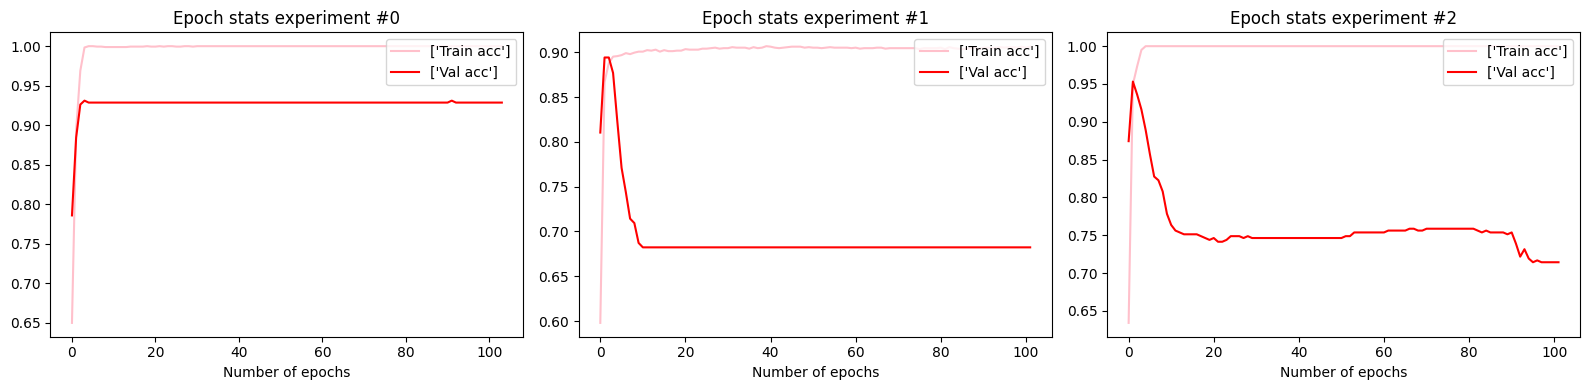

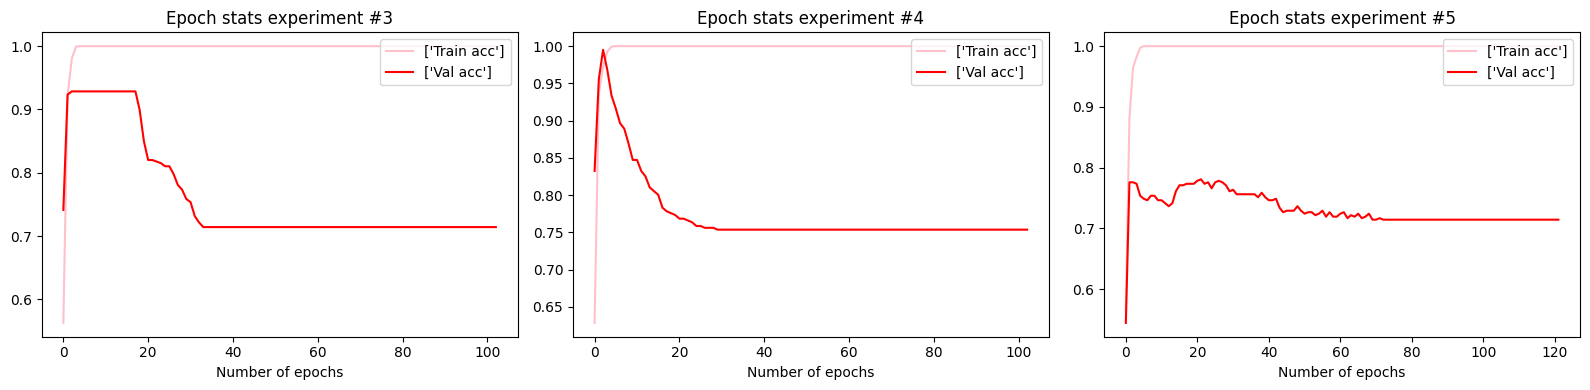

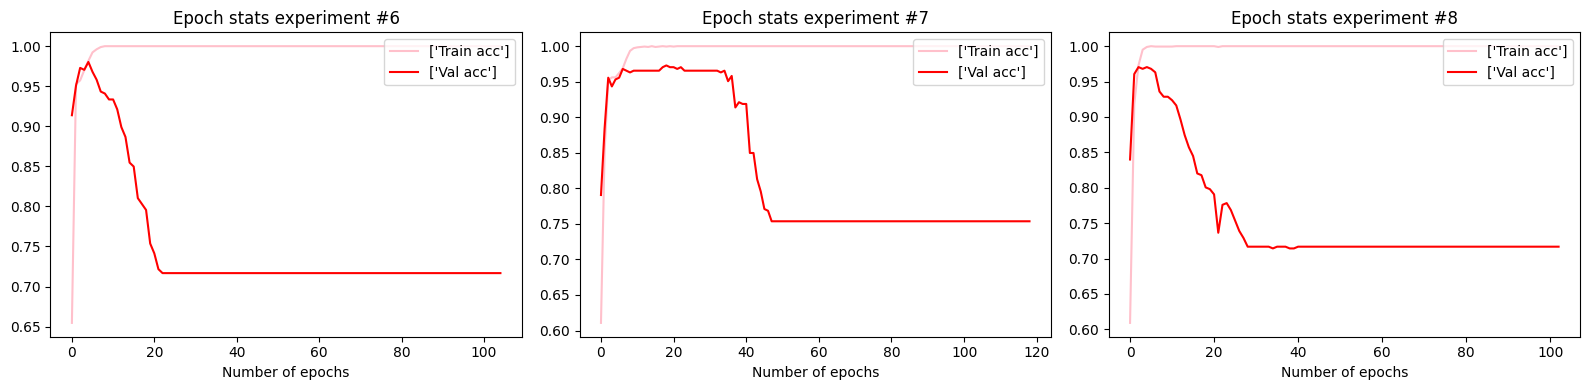

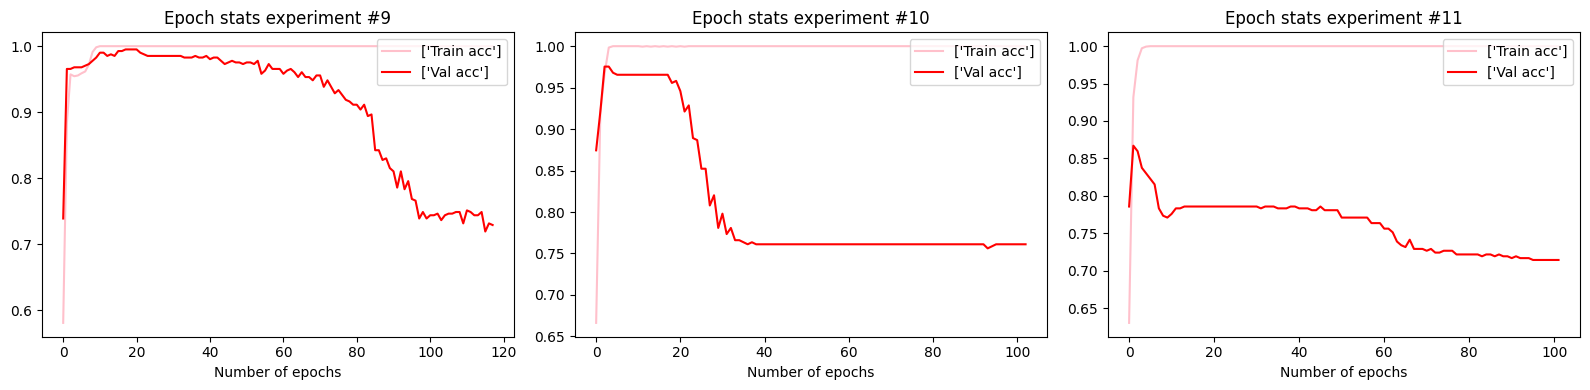

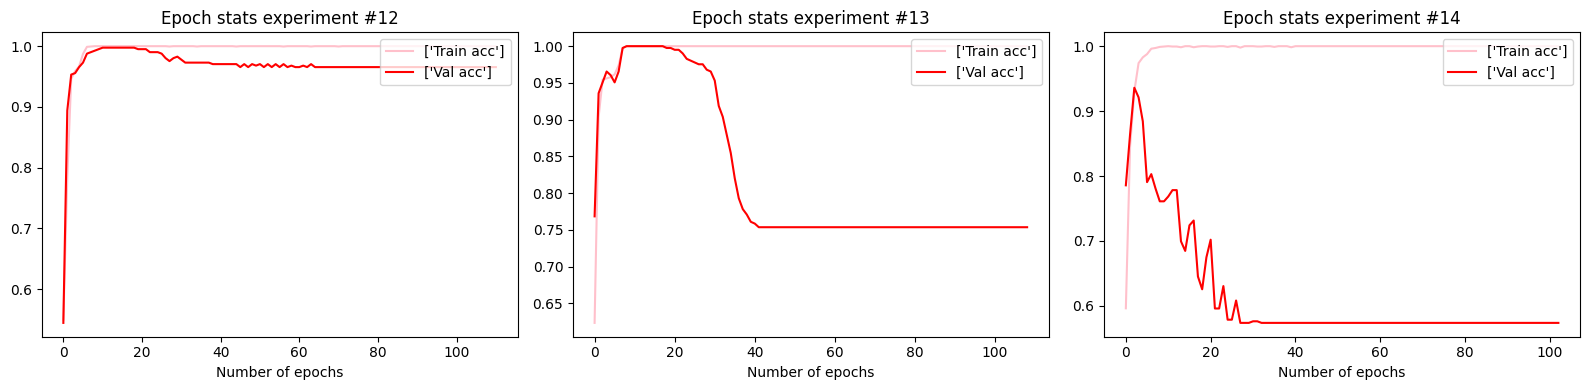

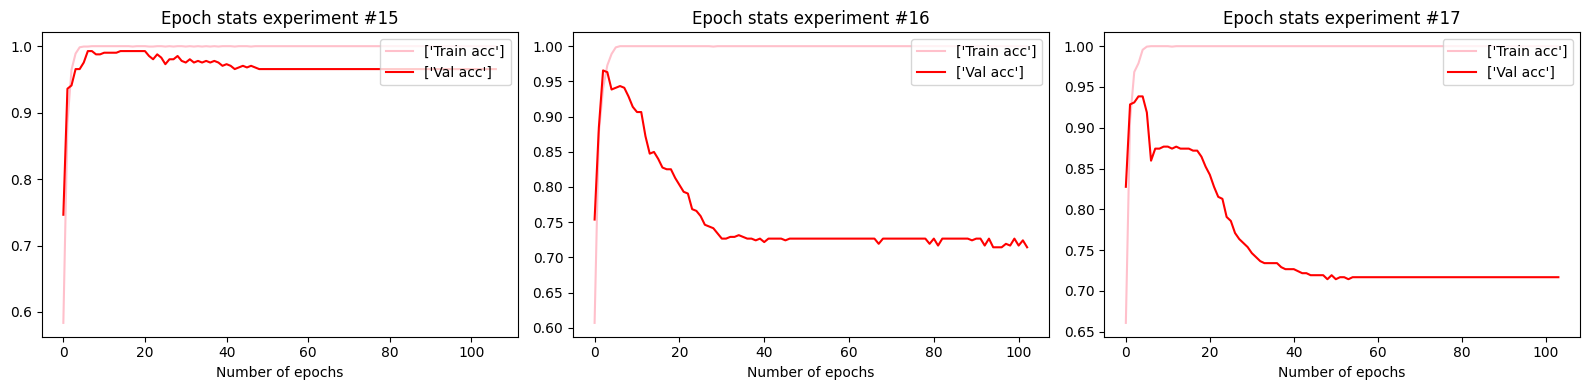

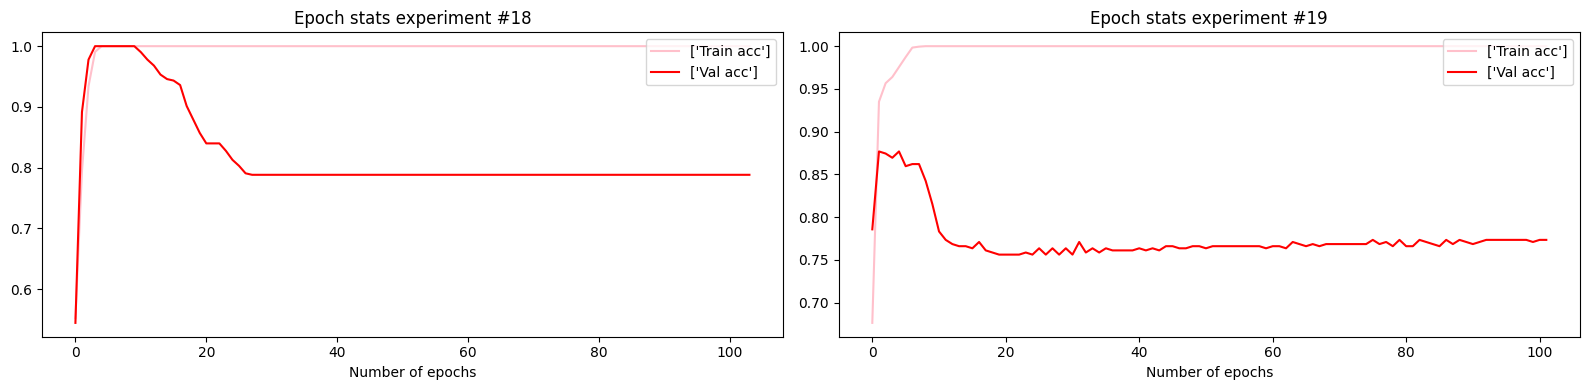

In [34]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

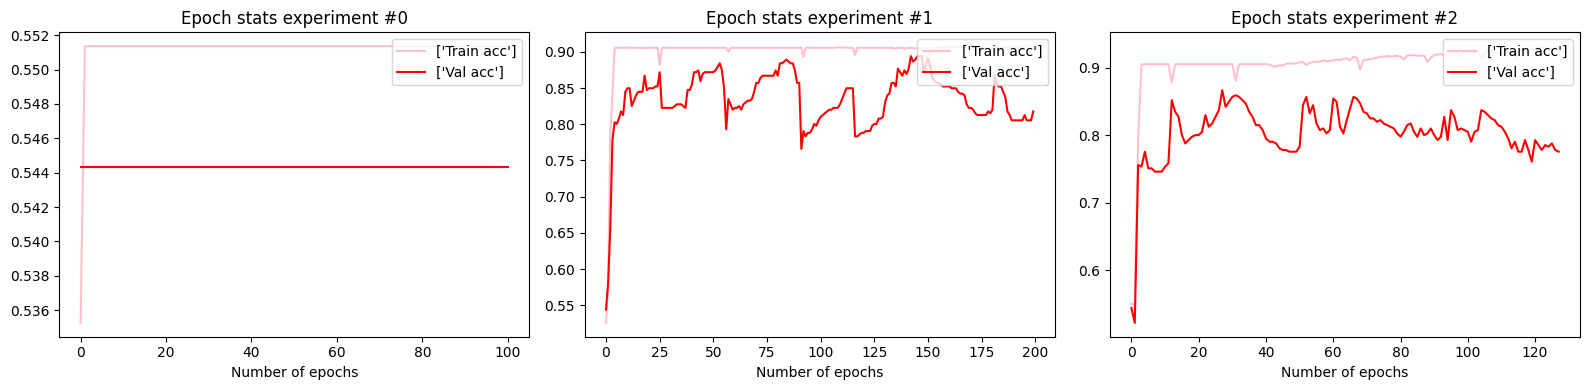

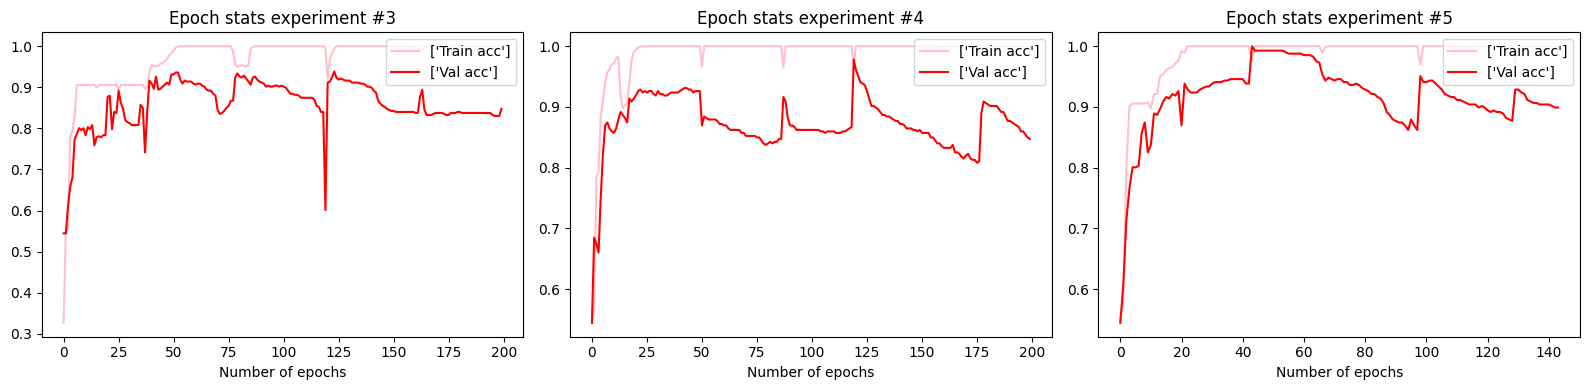

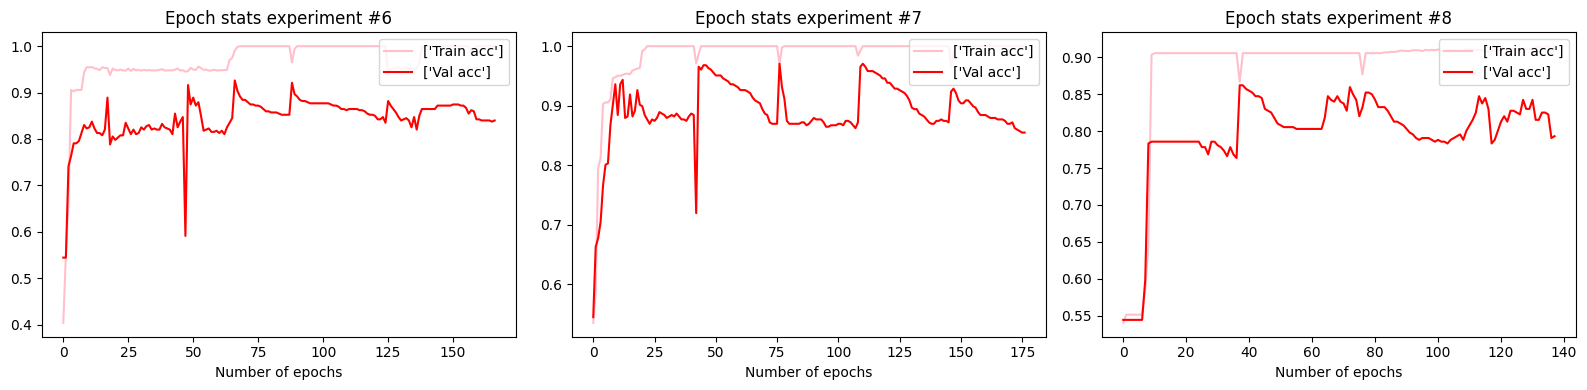

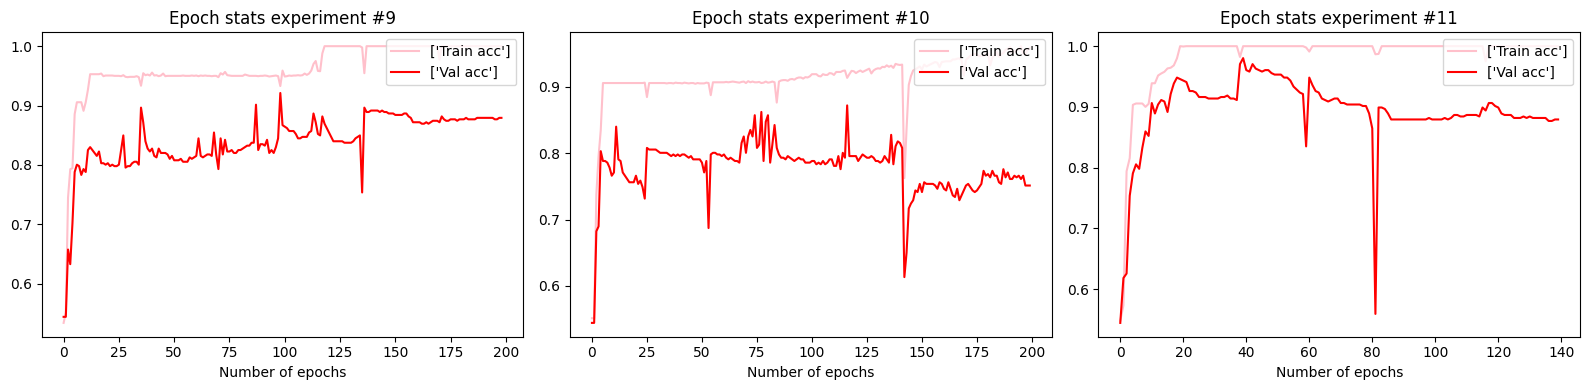

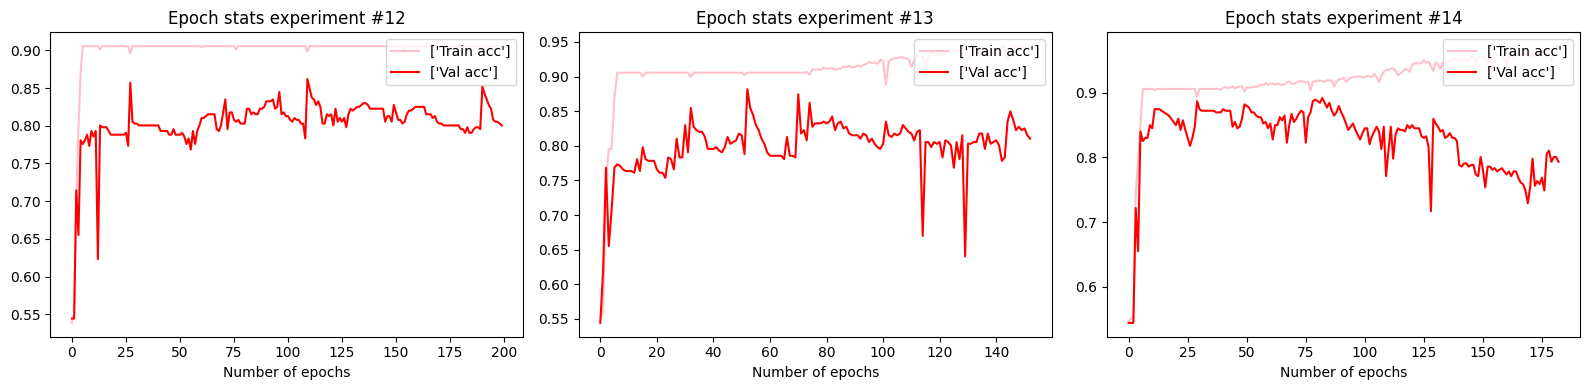

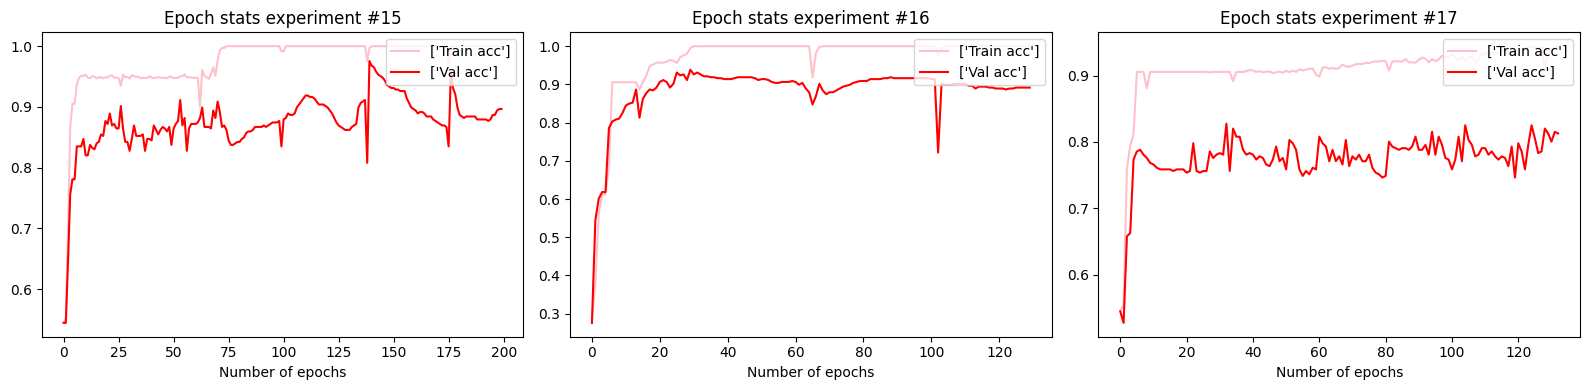

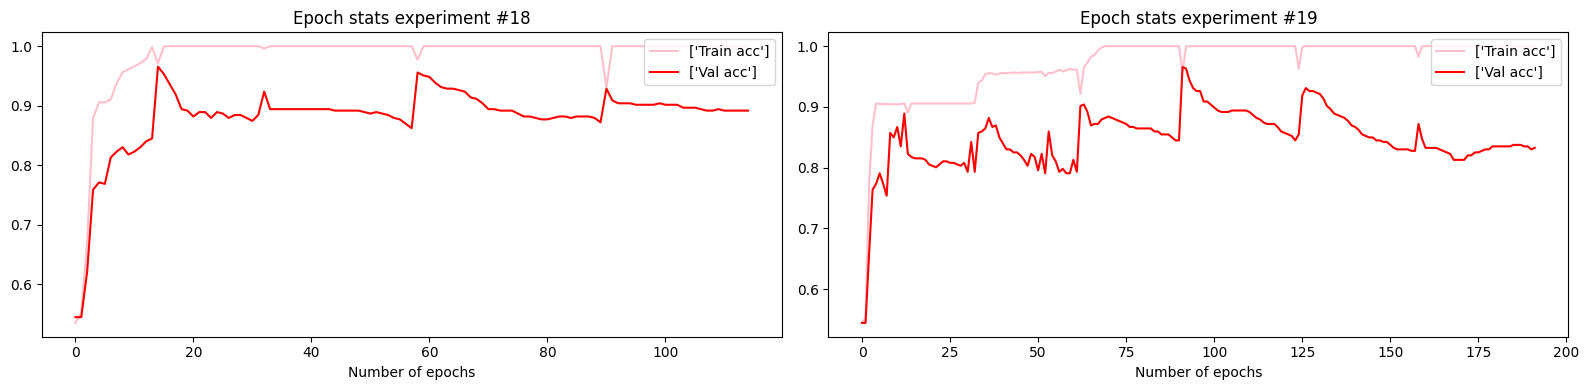

In [35]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

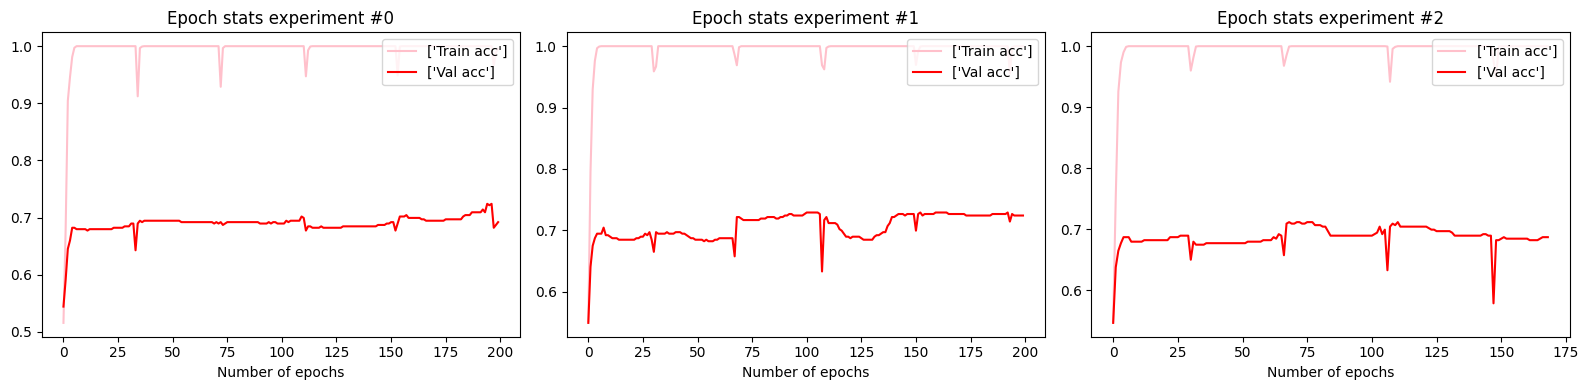

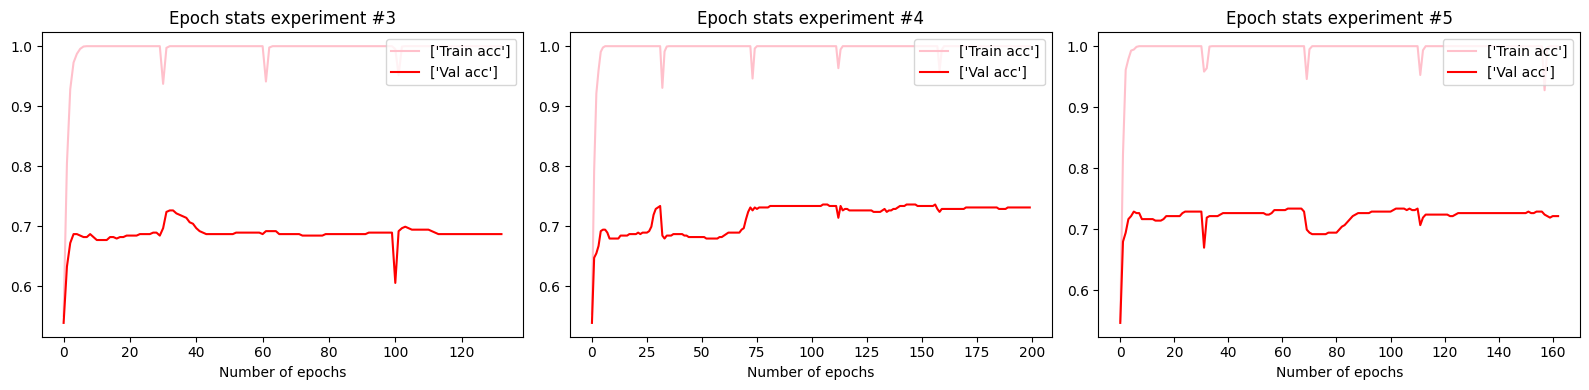

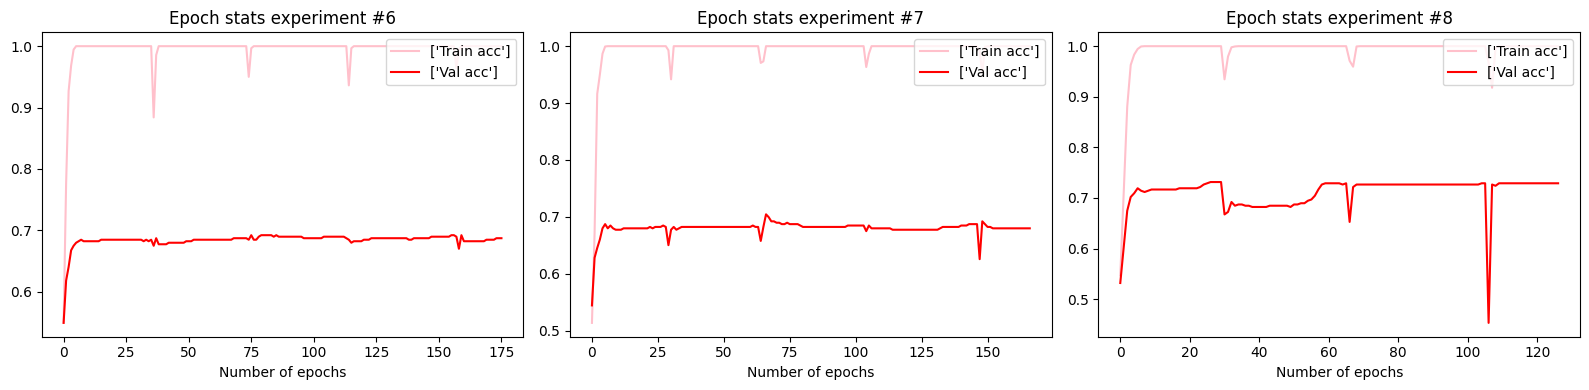

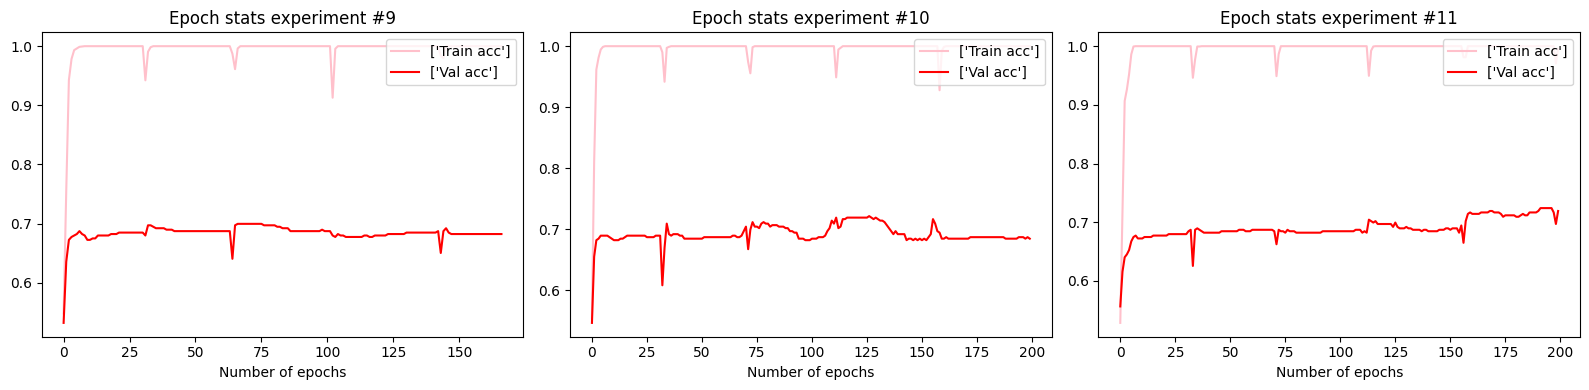

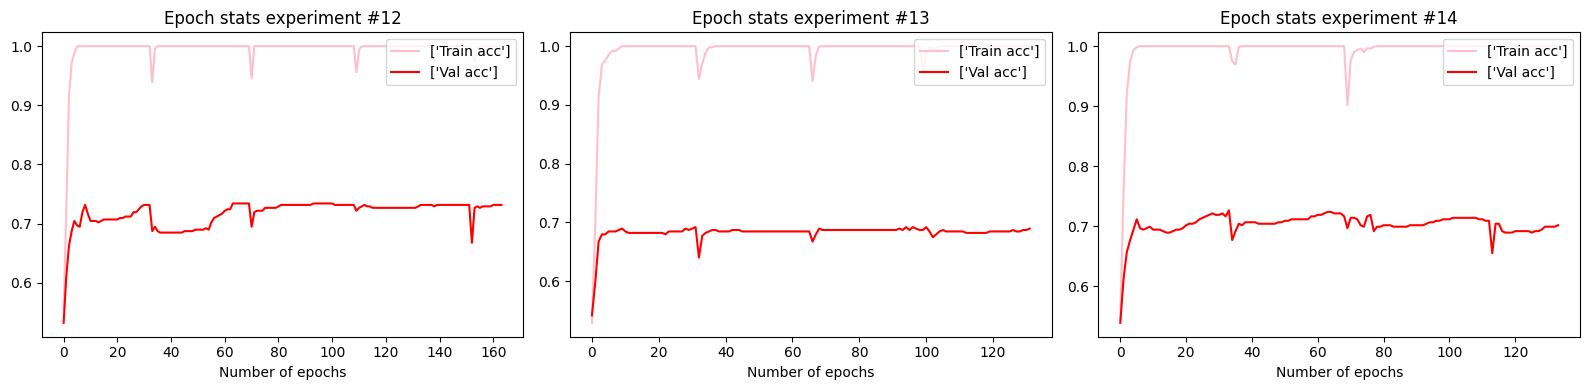

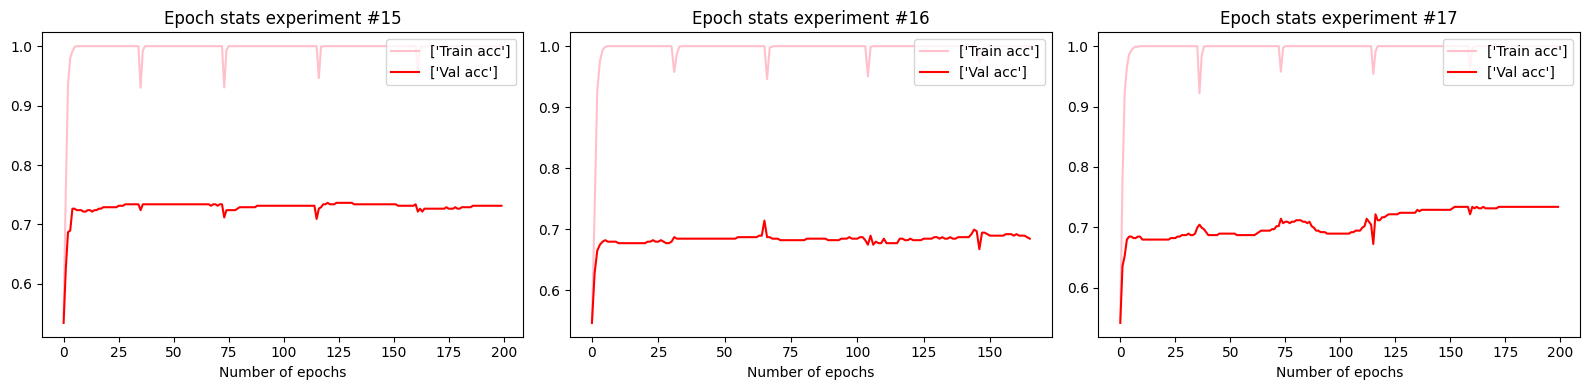

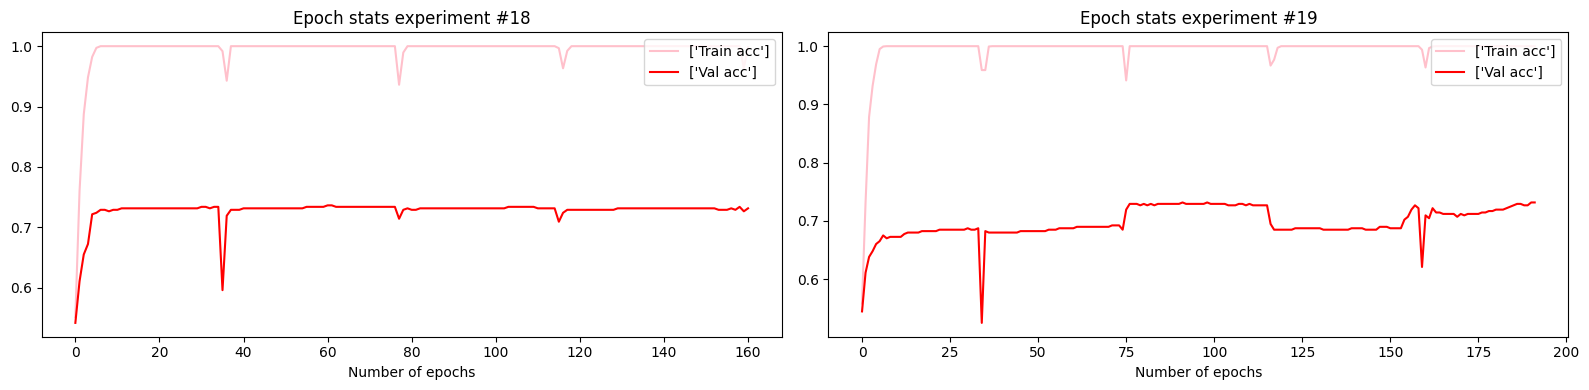

In [36]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

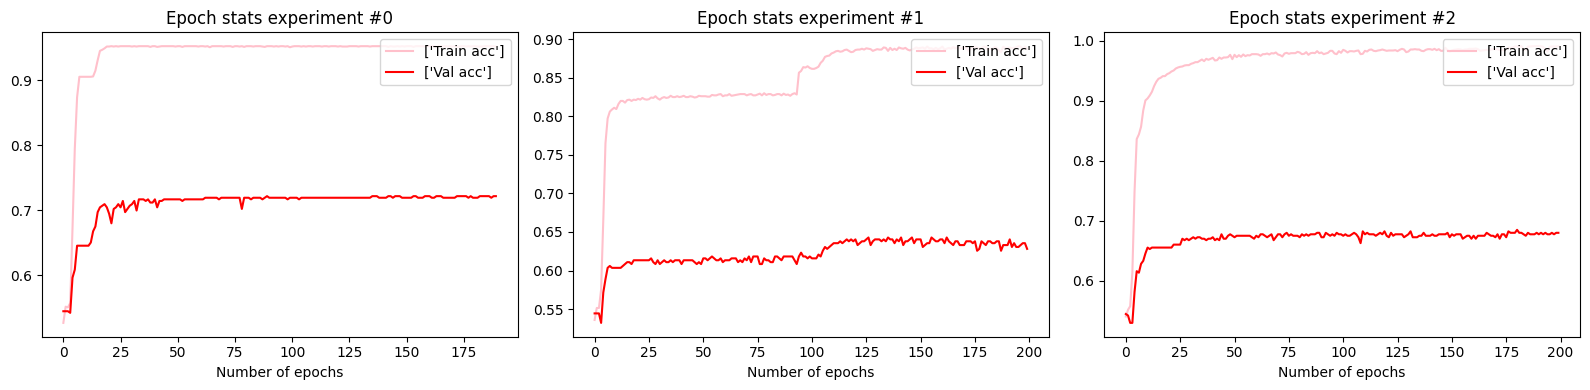

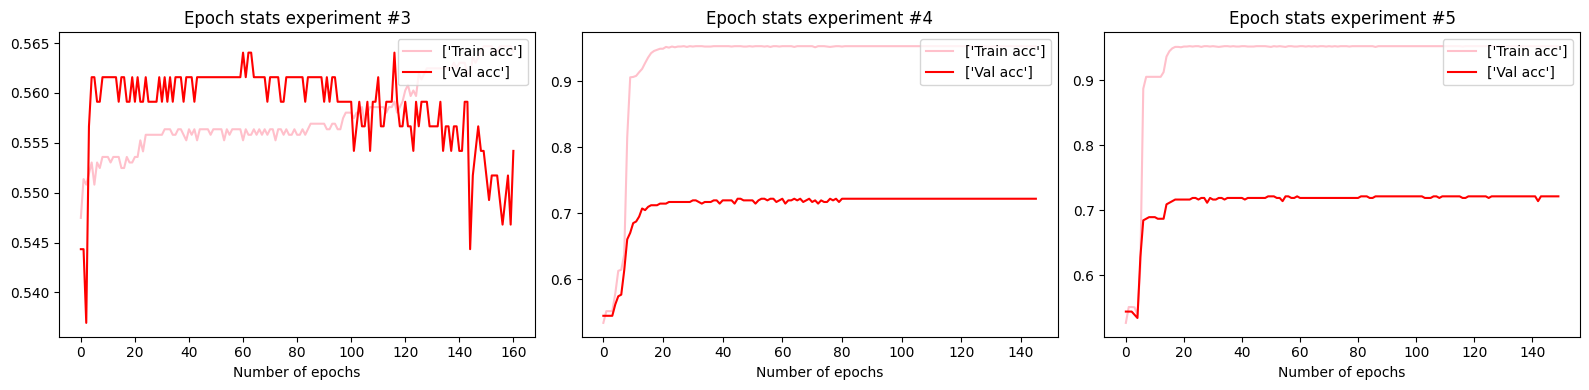

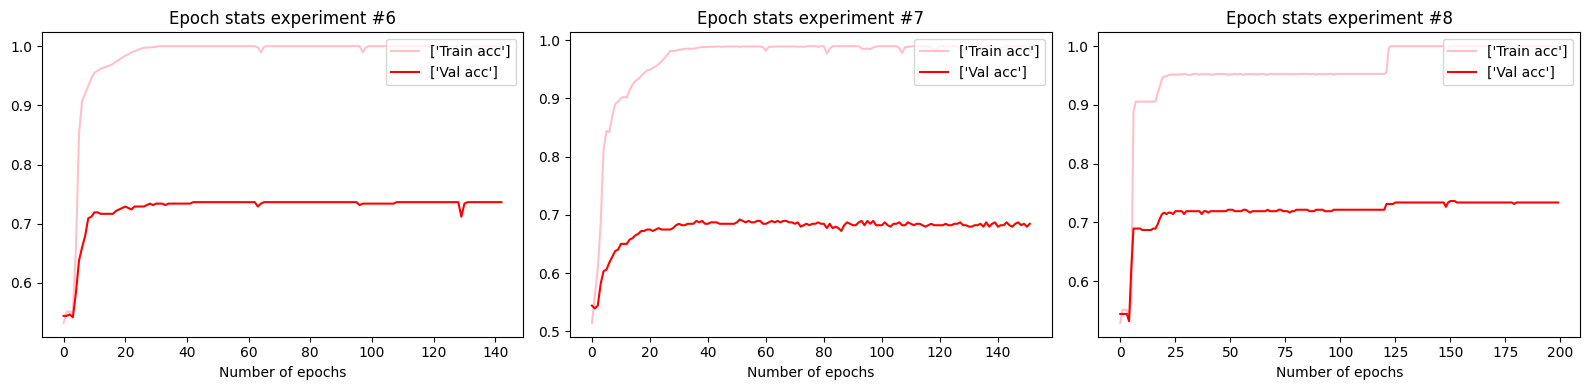

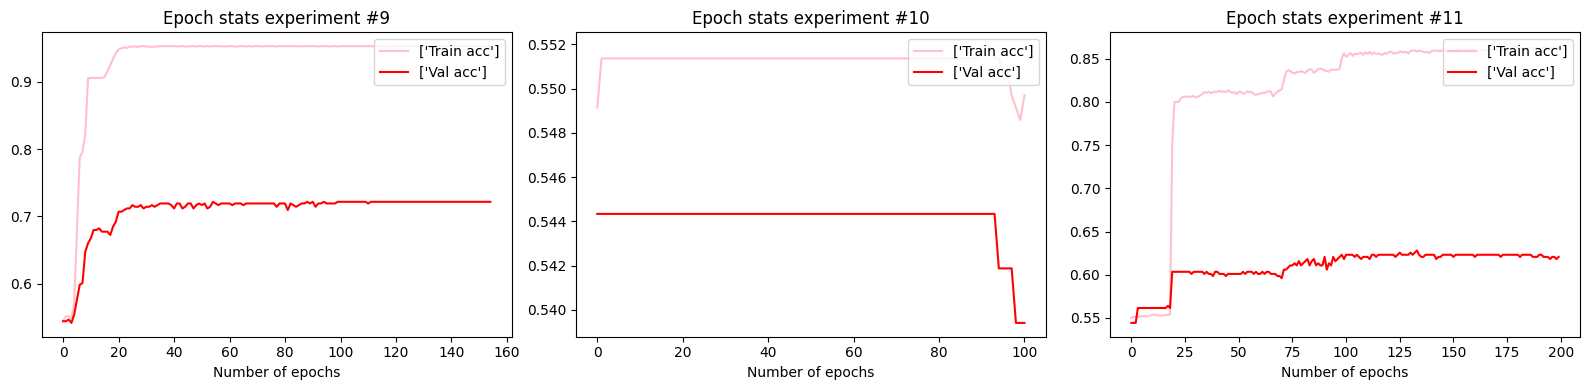

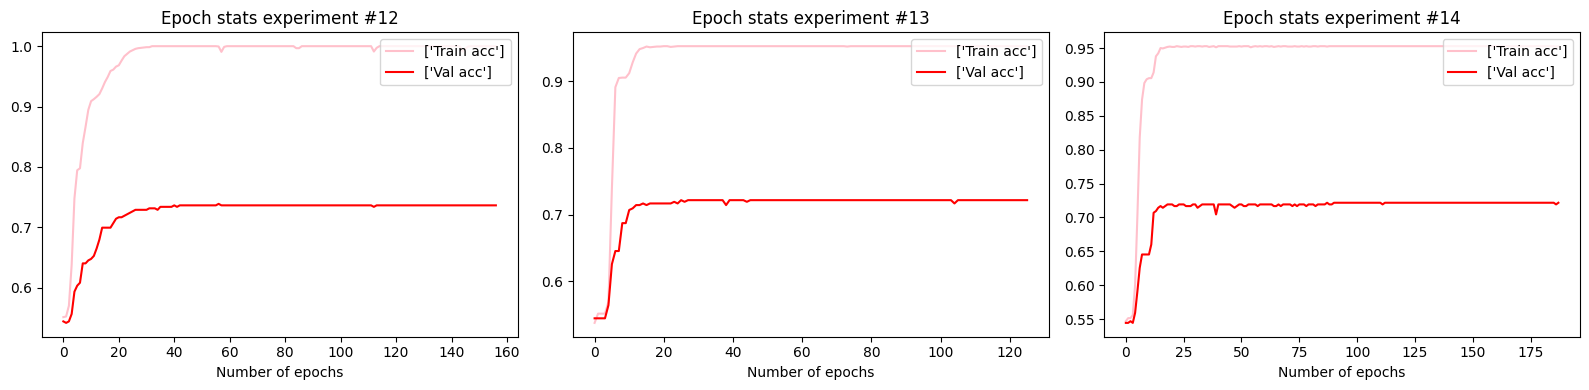

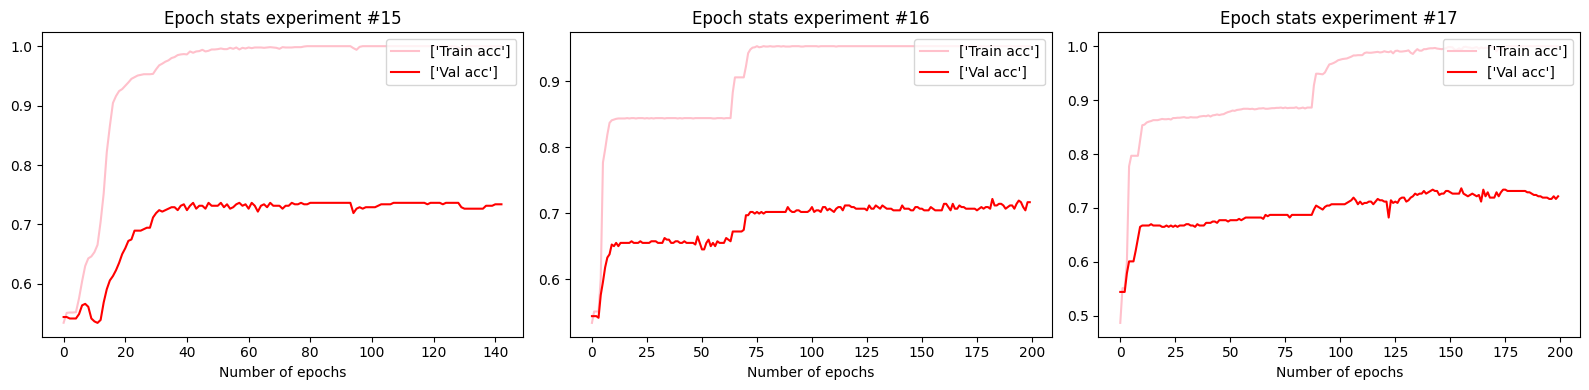

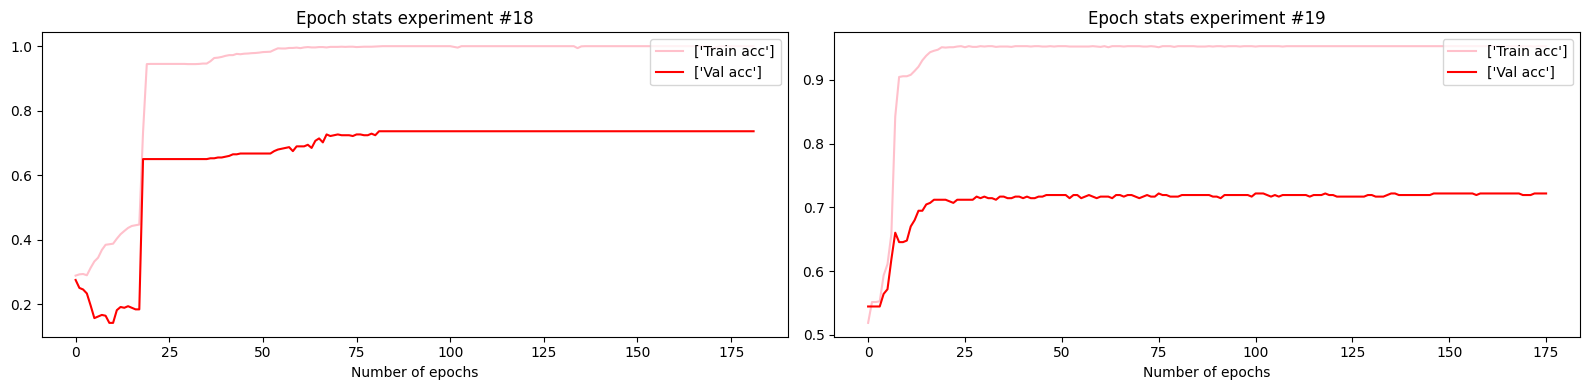

In [37]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

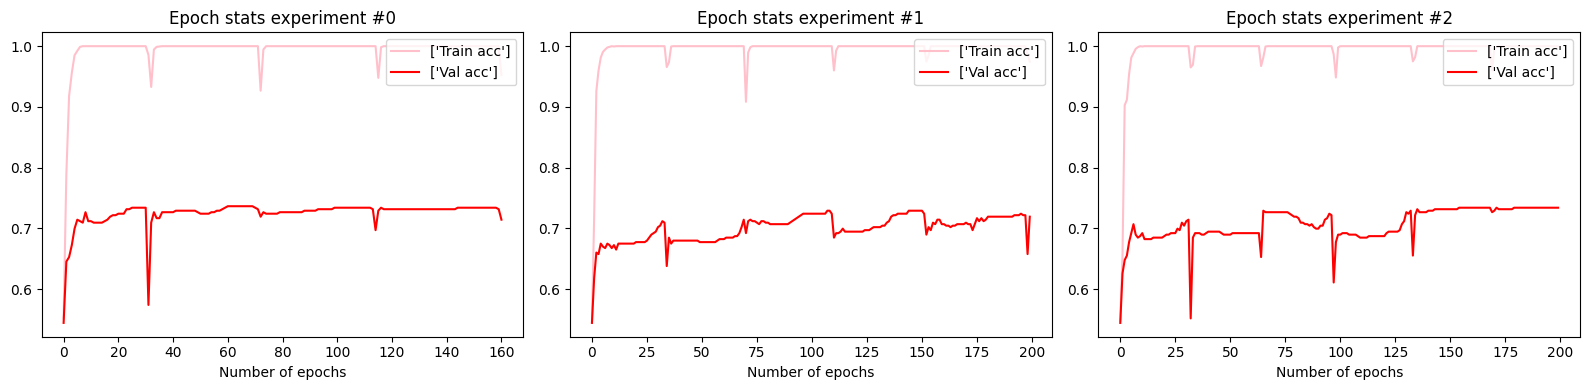

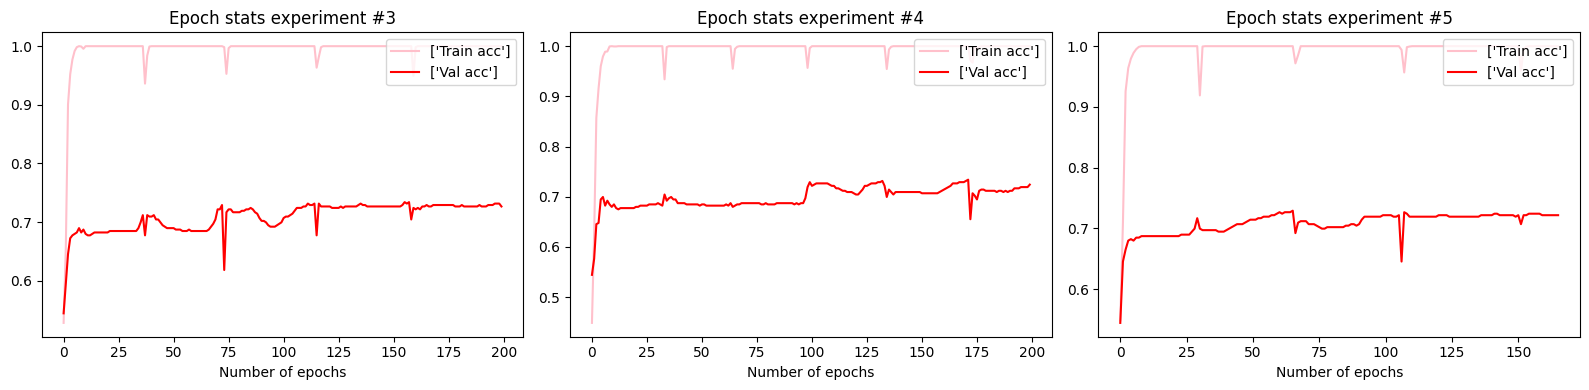

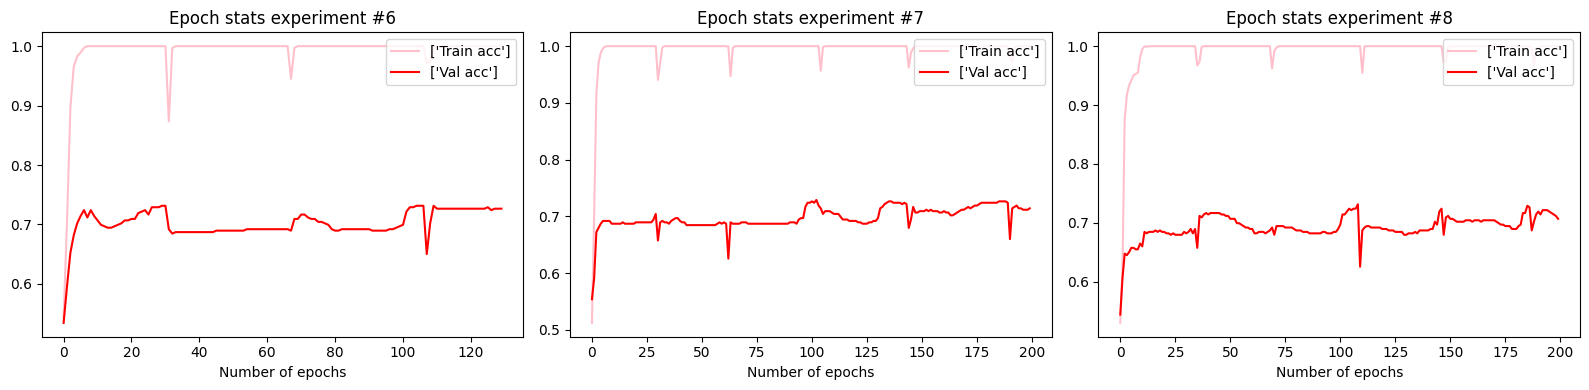

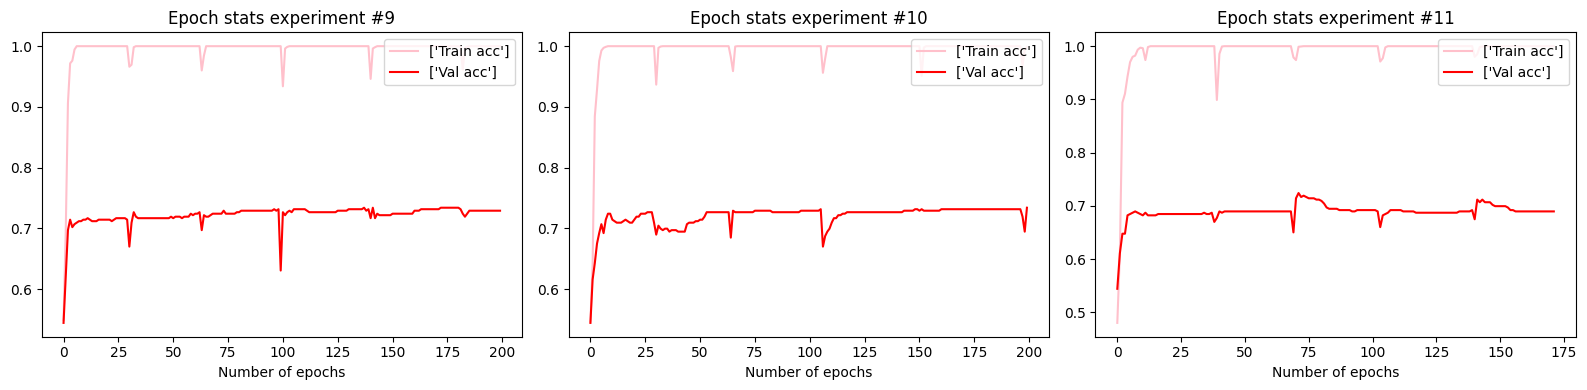

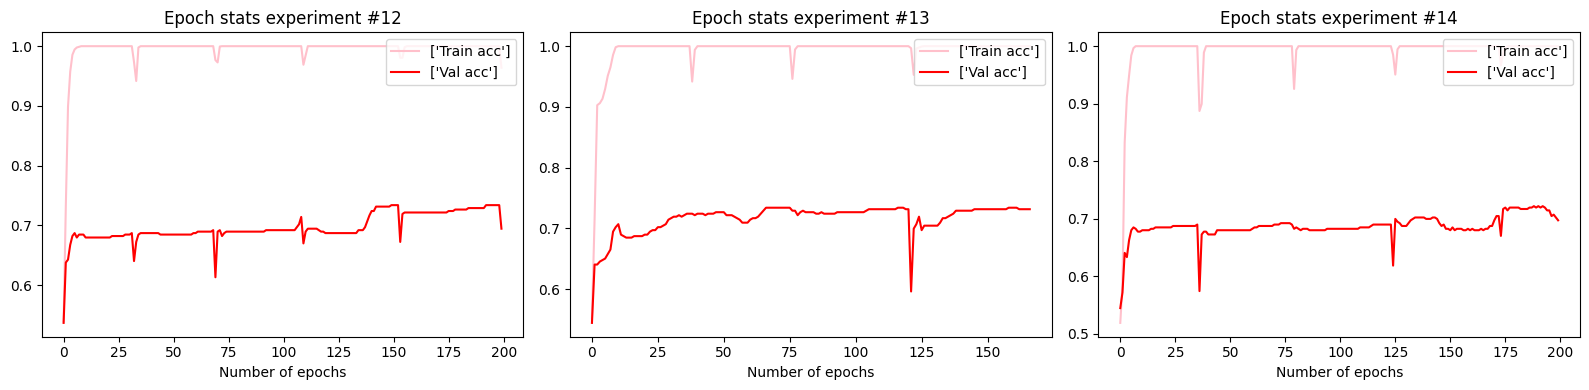

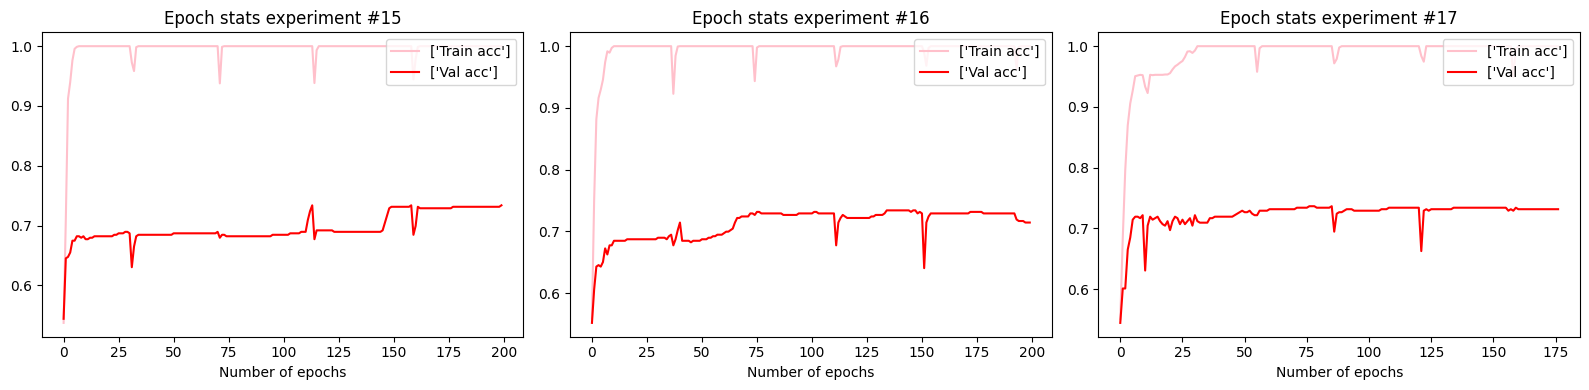

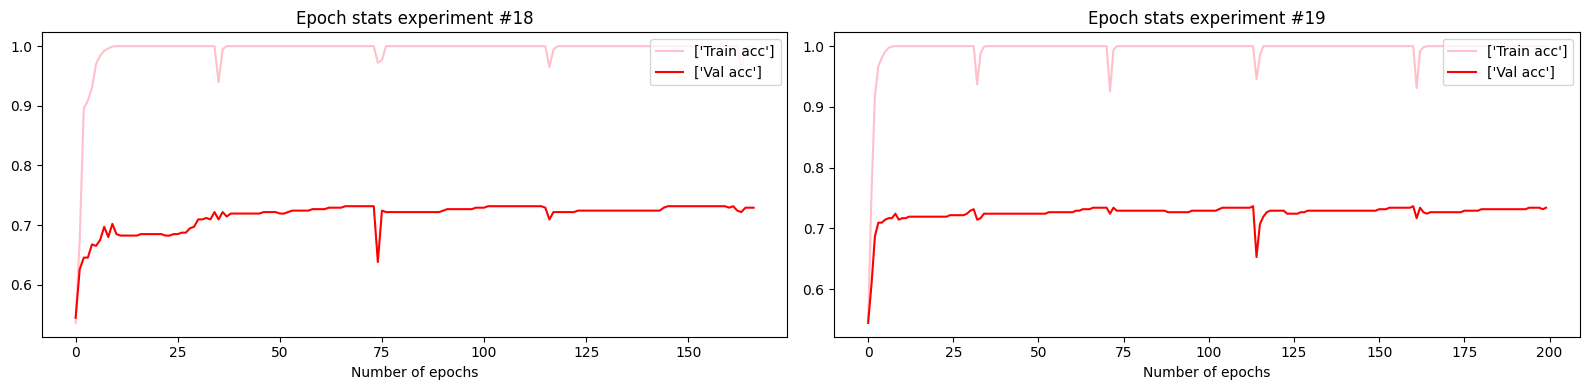

In [38]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [39]:
best_lstm_model = LSTM_Model(data, 16, 16, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

<All keys matched successfully>

In [43]:
def get_wrong_predictions_bycases(model, x_test, y_test, original_test_samples):
    model.eval()
    
    fa = []
    fd = []
    fr = []
    fv = []
    
    output = model(x_test[0], x_test[1], x_test[2])
    y_pred = torch.argmax(output, dim=1)  # Clasificacion Multiclase
    
    y_test = y_test.long() 
     
    for i in range(len(y_pred)):
        if y_test[i] == 0:
            if y_pred[i] != 0:fa.append((original_test_samples[i],decode(y_pred[i]))) #Wrong atomicity cases     
        elif y_test[i] == 1:
            if y_pred[i] != 1:fd.append((original_test_samples[i],decode(y_pred[i]))) #Wrong deadlock cases
        elif y_test[i] == 2:
            if y_pred[i] != 2:fr.append((original_test_samples[i],decode(y_pred[i]))) #Wrong datarace cases
        elif y_test[i] == 3:
            if y_pred[i] != 3:fv.append((original_test_samples[i],decode(y_pred[i]))) #Wrong valid cases

    return fa, fd, fr, fv

def filter_top_k_accuracies(accuracies, top_k):
    return heapq.nlargest(top_k, accuracies, key=lambda x: x['Overall'])

def print_wrong_preds_bycases(wrong_preds_list, k=10):
        a=0
        cases=["Atomicity violation", "DeadLock", "Data race", "Valid"]
        for i in wrong_preds_list:
            
            print(f'{min(k,len(i))} {cases[a]} cases wrong predicted:')   
            for j in range(min(k,len(i))):
                print(f"Sample {i[j][0]} | Prediction {i[j][1]}")
            a+=1
            print("\n")


## Top wrong predictions for best performing CNN model

In [44]:
print_wrong_preds_bycases([get_wrong_predictions_bycases(best_cnn_model, x_test_cnn, y_test, test_original)], 10)

4 Atomicity violation cases wrong predicted:


IndexError: list index out of range

## Top wrong predictions for best performing LSTM model

In [45]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

_,_,_.,,,w,u,... ,_.,._,,,,....r. | label: True | actual prediction: 0.022643083706498146
,,,.,._,w_u_,.,, ,.._.._,...,._r. | label: True | actual prediction: 0.03993787243962288
,,,.._,w.u...,_. .__.,___,,.__,r, | label: True | actual prediction: 0.04662638157606125
.,,._..w.u_____, ,.,,_,_..,.._r,, | label: True | actual prediction: 0.0647660419344902
,.,..,.,w,u,,_,, .....,,,,,.._r_, | label: True | actual prediction: 0.10447919368743896
,,,____,,_w_u,_. .__.,,.._._..,r_ | label: True | actual prediction: 0.1469869762659073
._,__,.._,.w.u_, ,.,,.___..,_,.r, | label: True | actual prediction: 0.14943338930606842
.__.__,___,,w.u. .,_...._,.,.,.r. | label: True | actual prediction: 0.1939167082309723
,_..,,.._.w_u,., _,..,._..,_..r__ | label: True | actual prediction: 0.23537883162498474
.___,___,,..u,w, ._.,_..,.,_.,d,r | label: True | actual prediction: 0.4487309157848358




## Top wrong predictions for best performing DeepSets V1 model

In [46]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,,_....,_,,.w.u, .,,._.,,_._,,.__ | label: False | actual prediction: 0.7841554284095764
.,,_,....,._.__. ,.._..,,_,.,_.., | label: False | actual prediction: 0.6407092809677124
_,__.__,._.w.u_, ,_,._..,,,_,_.,_ | label: False | actual prediction: 0.628642201423645

Top 10 false negatives: 

....__,_,,u.w.._ ____,.,,,,,_d_r. | label: True | actual prediction: 1.8631515558809042e-05
,,.,,.,_u_w__,., _,_,,,._,.._.d.r | label: True | actual prediction: 4.1812854760792106e-05
.__,_,.u_w._.__, .,,..,__,d.r,_.. | label: True | actual prediction: 5.8889490901492536e-05
,,._..._,._.__,_ __._,...._,,.r., | label: True | actual prediction: 6.146644591353834e-05
.__,__.__._w..._ __._,,__,,_..__r | label: True | actual prediction: 6.20306163909845e-05
.,,,_,...___..w, ,..,,,__.___.d.r | label: True | actual prediction: 6.778001261409372e-05
.,.,....,_.._._. _,,__.._._._,r.. | label: True | actual prediction: 9.149320976575837e-05
..,,,_,.u,w_.,,. ,._,_,_,,.d_r,_. | label:

## Top wrong predictions for best performing DeepSets V2 model

In [47]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

_._.,_._,.._,.,. ,,__._.,_,r_.___ | label: True | actual prediction: 0.5
_,___.,...w,_.._ _,..,,,.r._,.,.. | label: True | actual prediction: 0.5
_,,_.._..,,_.__. ..,,,,_..,...d.r | label: True | actual prediction: 0.5
__.__,_..,._,_,_ ,...._,.,_d.r__, | label: True | actual prediction: 0.5
._._.._,_u.w,,,. ,,,_,___d_r.__,, | label: True | actual prediction: 0.5
,_,.,_,.._,.,.,. ,,..,__,__r,..., | label: True | actual prediction: 0.5
_.,_..,_.._w,,._ _..__.,,,.,..r.. | label: True | actual prediction: 0.5
.,._.__,__,.,w., ...,,.,,d_r.,,,. | label: True | actual prediction: 0.5
,,,..__.....,w,_ __,_,_,,,..,.r,, | label: True | actual prediction: 0.5
._.__,,__,__,w,_ ..__.,,.._._r,_, | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [48]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

,_,__._u,w_,._,_ ___..,.,_._,d_r_ | label: True | actual prediction: 5.852445610798895e-06
__,_...u.w.,,_,_ ,,_.,.._.,__,r_. | label: True | actual prediction: 6.721300906065153e-06
..,.__..u.w_,.., ,..._,,.,,.d_r.. | label: True | actual prediction: 1.0249408660456538e-05
_..,.,,,,_..w,,, .,_.._,,,,.__..r | label: True | actual prediction: 1.1115055713162292e-05
.._._,__,..,,._. ,,___.,,.,,.r_.. | label: True | actual prediction: 1.1334764167258982e-05
.,._,_,,,..w.u.. .,_._,,,_r.,_.__ | label: True | actual prediction: 1.3317789125721902e-05
,,,,_..u.w_..__. .._.__.,____r,._ | label: True | actual prediction: 1.564160811540205e-05
....__,_,,u.w.._ ____,.,,,,,_d_r. | label: True | actual prediction: 1.593433989910409e-05
.,__..,,__.,,.,. _._..,,..,,,._r_ | label: True | actual prediction: 1.7726950318319723e-05
,,__.,....._..w_ _._.._.._,.,r.,, | label: True | actual prediction: 1.8750048184301704e-05




# Saving Notebook State

In [49]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [50]:
import dill
experiment_name = "f2_f4_easy_redo"
# dill.load_session('notebook_env_' + experiment_name + '.db')